# **IMPORTING REQUIRED LIBRARIES**





In [1]:
#pip install keras==2.3.0

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#from google.colab import files
import os
import zipfile

from glob import glob
from PIL import Image as pil_image
from matplotlib.pyplot import imshow, imsave
from IPython.display import Image as Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras.utils.np_utils import to_categorical
import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Concatenate, GlobalAveragePooling2D
from keras.optimizers import Adam, SGD
from keras import regularizers, initializers
from keras.layers.advanced_activations import LeakyReLU, ReLU, Softmax
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers.merge import concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import *
from keras.utils import plot_model
from keras.models import load_model

Using TensorFlow backend.
C:\Users\shiva\anaconda3\envs\project\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\shiva\anaconda3\envs\project\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\shiva\anaconda3\envs\project\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\shiva\anaconda3\envs\project\lib

# **DATA ANALYSIS**

In [2]:
# LOADING THE DATASET CSV IN PANDAS DATAFRAME
main_df = pd.read_csv('HAM10000_metadata.csv')
main_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


C:\Users\shiva\anaconda3\envs\project\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='dx', ylabel='count'>

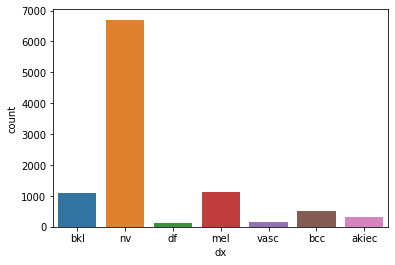

In [3]:
sns.countplot(main_df['dx'])

In [4]:
main_df['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

C:\Users\shiva\anaconda3\envs\project\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'scalp'),
  Text(1, 0, 'ear'),
  Text(2, 0, 'face'),
  Text(3, 0, 'back'),
  Text(4, 0, 'trunk'),
  Text(5, 0, 'chest'),
  Text(6, 0, 'upper extremity'),
  Text(7, 0, 'abdomen'),
  Text(8, 0, 'unknown'),
  Text(9, 0, 'lower extremity'),
  Text(10, 0, 'genital'),
  Text(11, 0, 'neck'),
  Text(12, 0, 'hand'),
  Text(13, 0, 'foot'),
  Text(14, 0, 'acral')])

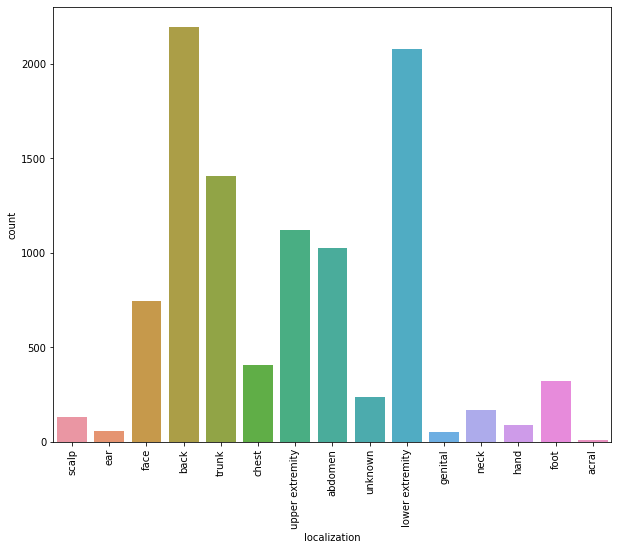

In [5]:
plt.figure(figsize=(10,8))
sns.countplot(main_df['localization'])
plt.xticks(rotation=90)

C:\Users\shiva\anaconda3\envs\project\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='dx_type', ylabel='count'>

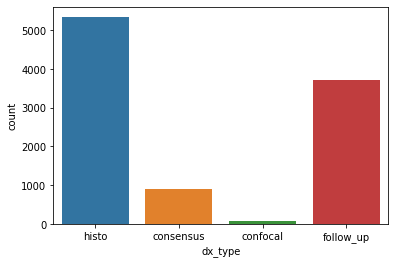

In [6]:
sns.countplot(main_df['dx_type'])

In [7]:
main_df['dx_type'].value_counts()

histo        5340
follow_up    3704
consensus     902
confocal       69
Name: dx_type, dtype: int64

In [8]:
# FINDING THE NUMBER OF MISSING VALUES 
main_df.isna().sum().sort_values(ascending=False)

age             57
localization     0
sex              0
dx_type          0
dx               0
image_id         0
lesion_id        0
dtype: int64

In [9]:
print(main_df['age'].mean())
print(main_df['age'].median())
main_df['age'].fillna(main_df['age'].mean(),inplace=True)

51.863828077927295
50.0


<AxesSubplot:xlabel='age', ylabel='Density'>

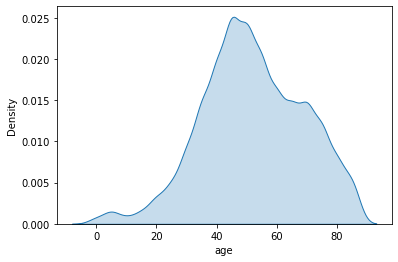

In [10]:
sns.kdeplot(main_df['age'],shade=True)

In [11]:
main_df['sex'].value_counts()

male       5406
female     4552
unknown      57
Name: sex, dtype: int64

In [12]:
# CREATING A DICTIONARY TO FEED IN LABEL VALUES IN OUR DATAFRAME
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

lesion_classes_dict = {
    0: 'Melanocytic nevi',
    1: 'Melanoma',
    2: 'Benign keratosis-like lesions ',
    3: 'Basal cell carcinoma',
    4: 'Actinic keratoses',
    5: 'Vascular lesions',
    6: 'Dermatofibroma'
}

main_df['cell_type'] = main_df['dx'].map(lesion_type_dict)

In [13]:
  main_df['cell_type_idx'] = pd.Categorical(main_df['cell_type']).codes

In [14]:
# CREATING IMAGE PATH
image_path = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join('', '*', '*.jpg'))}
print(image_path)

{'ISIC_0024306': 'HAM10000_images_part_1\\ISIC_0024306.jpg', 'ISIC_0024307': 'HAM10000_images_part_1\\ISIC_0024307.jpg', 'ISIC_0024308': 'HAM10000_images_part_1\\ISIC_0024308.jpg', 'ISIC_0024309': 'HAM10000_images_part_1\\ISIC_0024309.jpg', 'ISIC_0024310': 'HAM10000_images_part_1\\ISIC_0024310.jpg', 'ISIC_0024311': 'HAM10000_images_part_1\\ISIC_0024311.jpg', 'ISIC_0024312': 'HAM10000_images_part_1\\ISIC_0024312.jpg', 'ISIC_0024313': 'HAM10000_images_part_1\\ISIC_0024313.jpg', 'ISIC_0024314': 'HAM10000_images_part_1\\ISIC_0024314.jpg', 'ISIC_0024315': 'HAM10000_images_part_1\\ISIC_0024315.jpg', 'ISIC_0024316': 'HAM10000_images_part_1\\ISIC_0024316.jpg', 'ISIC_0024317': 'HAM10000_images_part_1\\ISIC_0024317.jpg', 'ISIC_0024318': 'HAM10000_images_part_1\\ISIC_0024318.jpg', 'ISIC_0024319': 'HAM10000_images_part_1\\ISIC_0024319.jpg', 'ISIC_0024320': 'HAM10000_images_part_1\\ISIC_0024320.jpg', 'ISIC_0024321': 'HAM10000_images_part_1\\ISIC_0024321.jpg', 'ISIC_0024322': 'HAM10000_images_part_1

In [15]:
main_df['path'] = main_df['image_id'].map(image_path.get)
main_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,HAM10000_images_part_1\ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,HAM10000_images_part_1\ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,HAM10000_images_part_1\ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,HAM10000_images_part_1\ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,2,HAM10000_images_part_2\ISIC_0031633.jpg


In [16]:
image_example = np.asarray(pil_image.open(main_df['path'][0]))

In [17]:
image_example.shape

(450, 600, 3)

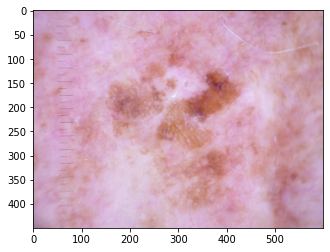

In [18]:
# PRINTING A SAMPLE IMAGE
plt.imshow(image_example)

In [19]:
# RESIZING THE IMAGE TO SMALLER SIZE TO MAKE TRAINING EASY
main_df['image'] = main_df['path'].map(lambda x: np.asarray(pil_image.open(x).resize((120,90))))

In [20]:
main_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx,path,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,HAM10000_images_part_1\ISIC_0027419.jpg,"[[[190, 152, 194], [192, 155, 197], [191, 154,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,HAM10000_images_part_1\ISIC_0025030.jpg,"[[[24, 13, 22], [24, 14, 23], [24, 14, 26], [2..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,HAM10000_images_part_1\ISIC_0026769.jpg,"[[[185, 126, 135], [189, 133, 145], [192, 135,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,HAM10000_images_part_1\ISIC_0025661.jpg,"[[[24, 11, 17], [25, 11, 20], [31, 16, 27], [4..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,2,HAM10000_images_part_2\ISIC_0031633.jpg,"[[[131, 89, 111], [143, 98, 121], [153, 108, 1..."


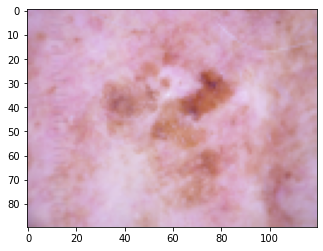

In [21]:
plt.imshow(main_df['image'][0])

In [22]:
main_df['image'][0].shape

(90, 120, 3)

# **PRINTING IMAGES OF EACH CLASS**

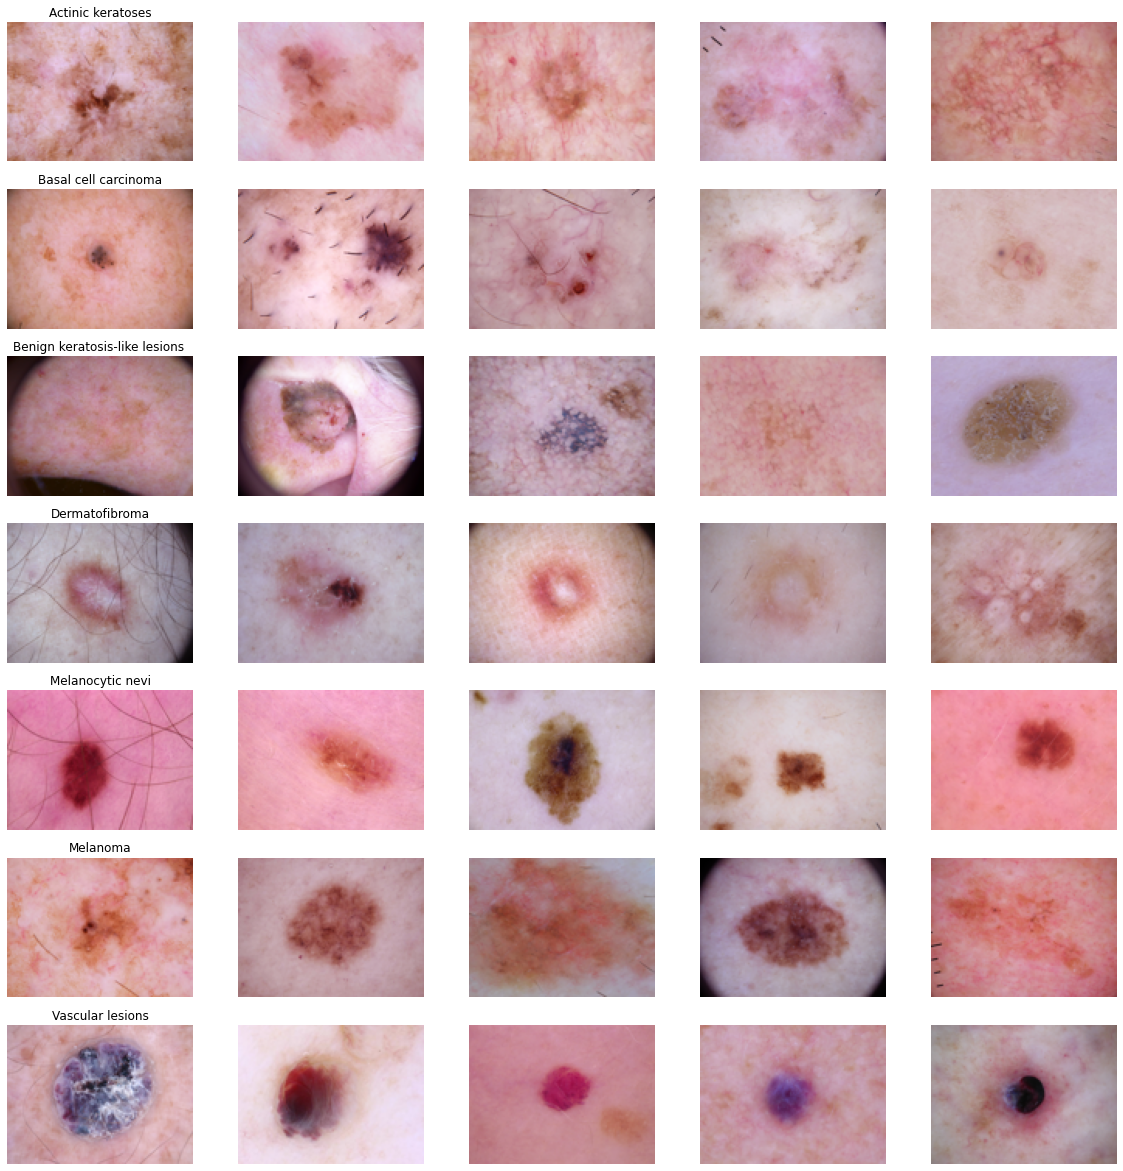

In [23]:

fig,axes = plt.subplots(7,5,figsize=(20,21))
for nth_axis,(cell_type_name,cell_type_row) in zip(axes,main_df.sort_values(['cell_type']).groupby('cell_type')):
    nth_axis[0].set_title(cell_type_name)
    for column_axis,(_,column_row) in zip(nth_axis,cell_type_row.sample(5).iterrows()):
        column_axis.imshow(column_row['image'])  
        column_axis.axis('off')

# **DATA PROCESSING AND MODELING**

In [24]:
features = main_df.drop(['cell_type_idx'],axis=1)

target = main_df['cell_type_idx']

# SPLITTING THE DATASETS INTO TRAIN AND TEST SET
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(features,target,test_size=0.01)

In [25]:
# CREATING IMAGE TRAINING AND TEST SET
x_train = np.asarray(X_TRAIN['image'].tolist())
x_test = np.asarray(X_TEST['image'].tolist())

In [26]:
print(x_train.shape)
print(x_test.shape)

(9914, 90, 120, 3)
(101, 90, 120, 3)


In [27]:
train_mean = x_train.mean()
train_std = x_train.std()
test_mean = x_test.mean()
test_std = x_test.std()

In [28]:
print(train_mean)
print(train_std)
print(test_mean)
print(test_std)

159.80244323092174
46.46731042553528
161.25124434665688
45.11216924308196


# **IMAGE STANDARDIZATION**

In [29]:
x_train = (x_train-train_mean) / train_std
x_test = (x_test-test_mean) / test_std

In [30]:
print(Y_TRAIN.shape)
print(Y_TEST.shape)

(9914,)
(101,)


In [31]:
# CONVERTING NX1 TO NX7 SINCE WE HAVE 7 CLASSES 
y_train = to_categorical(Y_TRAIN,num_classes=7)
y_test = to_categorical(Y_TEST,num_classes=7)

In [32]:
print(y_train.shape)
print(y_test.shape)

(9914, 7)
(101, 7)


In [33]:
X_train,X_val, Y_train,Y_val = train_test_split(x_train,y_train,test_size=0.15)

In [34]:
# RESHAPING SO THAT WE CAN FEED THIS INTO OUR NEURAL NETWORK
X_train  = X_train.reshape(X_train.shape[0],90,120,3)
x_test  = x_test.reshape(x_test.shape[0],90,120,3)
X_val  = X_val.reshape(X_val.shape[0],90,120,3)

In [35]:
print(X_train.shape)
print(x_test.shape)
print(X_val.shape)

(8426, 90, 120, 3)
(101, 90, 120, 3)
(1488, 90, 120, 3)


# **MODEL**

In [36]:
# COMMAND TO INSTALL KERAS OPTIMIZERS
#pip install -q efficientnet
#git clone https://github.com/bckenstler/CLR.git
#pip install -q keras-radam
#git clone https://github.com/bojone/accum_optimizer_for_keras.git
#pip install -q keras-lr-multiplier

In [37]:
!pip install efficientnet

In [38]:
# IMPORTING THE EFFICIENTNETB3 MODEL
import tensorflow as tf
import keras
import efficientnet.tfkeras as efn

In [39]:
# INITIALIZING THE MODEL
model = efn.EfficientNetB3(weights ='noisy-student', include_top=False,
                           input_shape = (90, 120, 3))

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [40]:
# IMPORTING LIBRARIES
from tensorflow.keras.layers import GlobalAveragePooling2D,Dropout,Dense
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential,Model

In [41]:
# MAKING CHANGES IN THE OUTPUT LAYER OF EFFICIENTNETB3 MODEL
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)
predictions = Dense(7, activation="softmax")(x)
model = Model(inputs=model.input, outputs=predictions)

In [42]:
# COMPILING THE MODEL
model.compile(optimizer = Adam(0.001) , loss = "categorical_crossentropy", metrics=['accuracy'])

In [43]:
# SET A LEARNING RATE ANNEALER
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3, 
                                            factor=0.5, 
                                            min_lr=0.000001)

# **TRAINING THE DATA**

In [44]:
# WITH DATA AUGMENTATION TO PREVENT OVERFITTING

datagen = ImageDataGenerator(
        rotation_range=10,  # RANDOMLY ROTATE IMAGES IN THE RANGE (0 - 180)
        zoom_range = 0.1 # RANDOMLY ZOOM IMAGES 
)


# FIT THE MODEL
epochs = 20
batch_size = 16
model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/20
526/526 [==============================] - 1139s 2s/step - loss: 0.8801 - acc: 0.6892 - val_loss: 0.7240 - val_acc: 0.7345
Epoch 2/20
526/526 [==============================] - 1098s 2s/step - loss: 0.7410 - acc: 0.7363 - val_loss: 0.7243 - val_acc: 0.7399
Epoch 3/20
526/526 [==============================] - 1025s 2s/step - loss: 0.6929 - acc: 0.7605 - val_loss: 0.6952 - val_acc: 0.7278
Epoch 4/20
526/526 [==============================] - 1073s 2s/step - loss: 0.6047 - acc: 0.7869 - val_loss: 0.5744 - val_acc: 0.7762
Epoch 5/20
526/526 [==============================] - 1067s 2s/step - loss: 0.5765 - acc: 0.8033 - val_loss: 0.6532 - val_acc: 0.7749
Epoch 6/20
526/526 [==============================] - 1089s 2s/step - loss: 0.5416 - acc: 0.8048 - val_loss: 0.5459 - val_acc: 0.8233
Epoch 7/20
526/526 [==============================] - 1415s 3s/step - loss: 0.4850 - acc: 0.8306 - val_loss: 0.5317 - val_acc: 0.8145
Epoch 8/20
526/526 [==============================] - 3125s 6s

# **PLOTTING GRAPH**

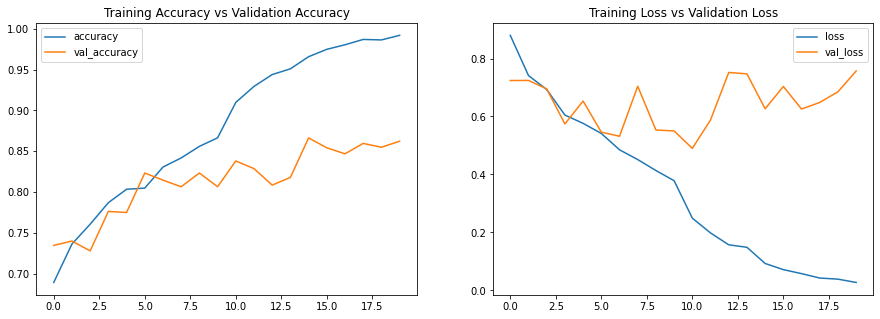

In [45]:
def plot_(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    f, [ax1, ax2] = plt.subplots(1,2, figsize=(15, 5))
    ax1.plot(range(len(acc)), acc, label="accuracy")
    ax1.plot(range(len(acc)), val_acc, label="val_accuracy")
    ax1.set_title("Training Accuracy vs Validation Accuracy")
    ax1.legend()

    ax2.plot(range(len(loss)), loss, label="loss")
    ax2.plot(range(len(loss)), val_loss, label="val_loss")
    ax2.set_title("Training Loss vs Validation Loss")
    ax2.legend()
    
    
plot_(model.history)

In [46]:
# PRINTING THE ACCURACY OF THE MODEL
print("MAXIMUM ACCURACY : ",
      round(max(model.history.history["val_acc"])*100,4))

MAXIMUM ACCURACY :  86.6263


# **SAVING THE MODEL**

In [47]:
model.save("model.h5")

In [48]:
model = efn.EfficientNetB3(weights ='noisy-student', include_top=False,
                           input_shape = (90, 120, 3))
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)
predictions = Dense(7, activation="softmax")(x)
model = Model(inputs=model.input, outputs=predictions)
model.compile(optimizer = Adam(0.001) , loss = "categorical_crossentropy", metrics=['accuracy'])

model.save_weights("model.h5")

# **PREDICTION OF IMAGE**

In [49]:
# RESIZING THE IMAGE
resized_image = np.asarray(pil_image.open('C:\\Users\\shiva\\Desktop\\project\\SkinCancer\\Code\\HAM10000_images_part_2\\ISIC_0029310.jpg').resize((120,90)))
image_array = np.asarray(resized_image.tolist())
test_image = image_array.reshape(1,90,120,3)

In [50]:
prediction_class = model.predict(test_image)
prediction_class = nphttp://localhost:8888/notebooks/SKIN_CANCER_PREDICTION.ipynb#.argmax(prediction_class,axis=1)

SyntaxError: invalid syntax (<ipython-input-50-81b27fa83a66>, line 2)

In [ ]:
prediction_class

In [ ]:
# PREDICTING THE IMAGE
lesion_classes_dict[prediction_class[0]]